In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation

In [4]:
import math

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN

### Carga de los datos:

In [7]:
name_f="international-airline-passengers.csv"

In [8]:
dataframe = pd.read_csv(name_f, sep=',', usecols=[1], engine='python', skipfooter=3)
dataframe[:] = dataframe[:].astype('float32') 
df_train, df_test = dataframe[0:96].values, dataframe[96:].values

Escalamiento de los datos:

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

In [10]:
def create_dataset(dataset,lag=1):
    t_data = len(dataset)
    dataset = dataset.reshape(t_data)
    dataY = dataset[lag:]
    t_dataY = len(dataY)
    dataX = np.zeros((t_dataY, lag))
    for i in range(t_dataY):
        dataX[i] = dataset[i:lag+i]
    return np.array(dataX),np.array(dataY)

**(j) Usando un lag de 3, compare el desempe no de la LSTM con una red recurrente simple y una GRU. Comente.**

De la actividad anterior pudimos verificar que un lag de 3 presento mejores resultados de Train Score: 21.31 RMSE
y Test Score: 54.33 RMSE, ahora compraremos con Gated recurrent units (GRUs) y Red recurrente tradicional.

### Cargar datos

In [30]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Crear Modelos 

In [31]:
model_gru = Sequential()
model_gru.add(GRU(input_dim=trainX.shape[2], output_dim=4, inner_init='orthogonal', activation='tanh'))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')
model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 4)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_SimpleRNN = Sequential()
model_SimpleRNN.add(SimpleRNN(input_dim=trainX.shape[2], output_dim=4, inner_init='orthogonal',activation='tanh'))        
model_SimpleRNN.add(Dense(1))
model_SimpleRNN.compile(loss='mean_squared_error', optimizer='adam')
model_SimpleRNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


### Fit Modelos

In [33]:
%%time
history_model_gru = model_gru.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)

CPU times: user 55.3 s, sys: 45.1 s, total: 1min 40s
Wall time: 45.4 s


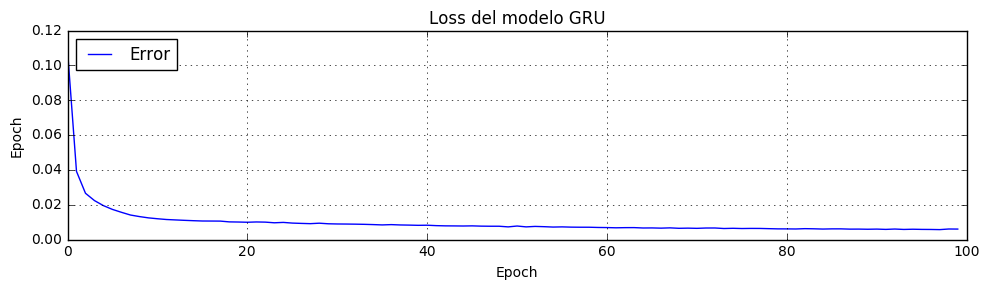

In [36]:
plt.figure(figsize=(10, 3))
plt.plot(history_model_gru.epoch,history_model_gru.history['loss'])  
plt.title('Loss del modelo GRU')  
plt.ylabel('Epoch')  
plt.xlabel('Epoch')  
plt.legend(['Error'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
%%time
history_model_SimpleRNN = model_SimpleRNN.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)

CPU times: user 25.5 s, sys: 16.6 s, total: 42.1 s
Wall time: 19 s


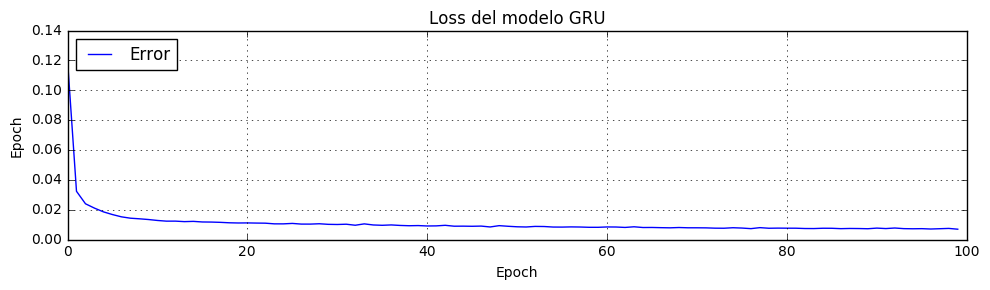

In [35]:
plt.figure(figsize=(10, 3))
plt.plot(history_model_SimpleRNN.epoch,history_model_SimpleRNN.history['loss'])  
plt.title('Loss del modelo GRU')  
plt.ylabel('Epoch')  
plt.xlabel('Epoch')  
plt.legend(['Error'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Predict con Modelos

Train Score model_gru: 23.01 RMSE
Test Score model_gru: 60.77 RMSE


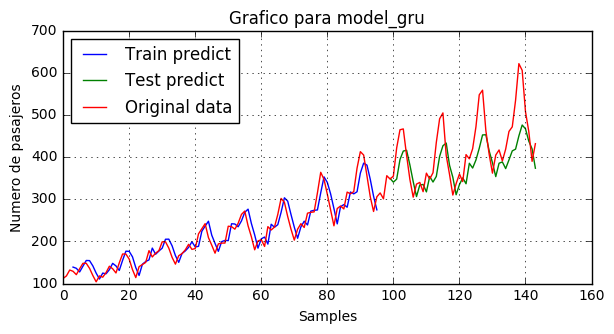

CPU times: user 475 ms, sys: 19.8 ms, total: 495 ms
Wall time: 481 ms


In [51]:
%%time
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainPredict = model_gru.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = model_gru.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score model_gru: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score model_gru: %.2f RMSE' % (testScore))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
plt.figure(figsize=(15, 15))
#####
plt.subplot(4, 2, 1)
plt.plot(trainPredictPlot) 
plt.plot(testPredictPlot)
plt.plot(dataframe)
plt.title('Grafico para model_gru')  
plt.ylabel('Numero de pasajeros')  
plt.xlabel('Samples')  
plt.legend(['Train predict', 'Test predict', 'Original data'], loc='upper left')
plt.grid(True)
plt.show()

Train Score model_SimpleRNN: 25.57 RMSE
Test Score model_SimpleRNN : 68.80 RMSE


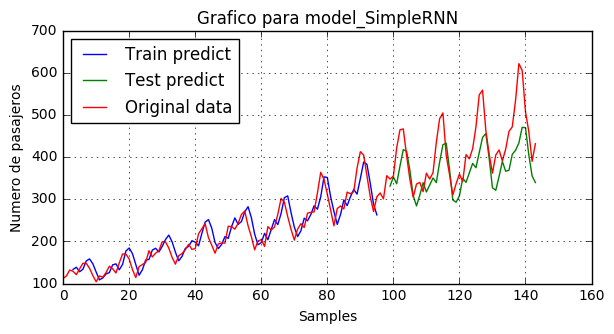

CPU times: user 478 ms, sys: 15.5 ms, total: 494 ms
Wall time: 484 ms


In [52]:
%%time
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainPredict = model_SimpleRNN.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = model_SimpleRNN.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score model_SimpleRNN: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score model_SimpleRNN : %.2f RMSE' % (testScore))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
plt.figure(figsize=(15, 15))
#####
plt.subplot(4, 2, 1)
plt.plot(trainPredictPlot) 
plt.plot(testPredictPlot)
plt.plot(dataframe)
plt.title('Grafico para model_SimpleRNN')  
plt.ylabel('Numero de pasajeros')  
plt.xlabel('Samples')  
plt.legend(['Train predict', 'Test predict', 'Original data'], loc='upper left')
plt.grid(True)
plt.show()

### Comentarios
---

<h3 align = 'center'> Variables </h3>

|lag | tipo|  Total params | time_traning |Train_RMSE|Test_RMSE
| :-: | :-: | :-: | :-: | :-: |:-: |:-: |:-: |
|3|GRU|491| 45.4 s| 23.01| 60.77|
|3|SimpleRNN|19 s| 40.8 s| 25.57| 68.80|

Recordando que LSTM obtuvo los siguentes resultados Train Score: 21.31 RMSE y Test Score: 54.33 RMSE, podemos ver que una Simple red recurrente presente un mejor resultado en el RMSE de entrenamiento, pero tambien esta bajo el efecto del overfitting. Otro antecedente es que el tiempo de entrenamiento de esta red es muy inferior a LSTM que fue de 41s. En el caso de la GRU, son tambien presenta mejores resultados de RMSE de entrenamiento pero con RMSE de test muy alto, aunque estas redes fueron diseñadas para topicos de sonido.